<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/RNN_Many_to_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

import tensorflow as tf

from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , Normalizer

Create data

In [ ]:
num_days = 500
dates = pd.date_range(start="2020-01-01", periods=num_days, freq="D")
oil_prices = 50 + 5 * np.sin(np.linspace(0, 20, num_days)) + np.random.normal(0, 1, num_days)
temperature = 30 + 10 * np.sin(np.linspace(0, 10, num_days)) + np.random.normal(0, 1, num_days)

df = pd.DataFrame({"Date": dates, "Oil_Price": oil_prices, "Temperature": temperature})

df.head()

,Date,Oil_Price,Temperature
0,2020-01-01,49.590613,30.833068
1,2020-01-02,49.705788,29.953748
2,2020-01-03,51.230852,29.924304
3,2020-01-04,50.646771,31.130562
4,2020-01-05,51.472634,30.708621


prepartation data

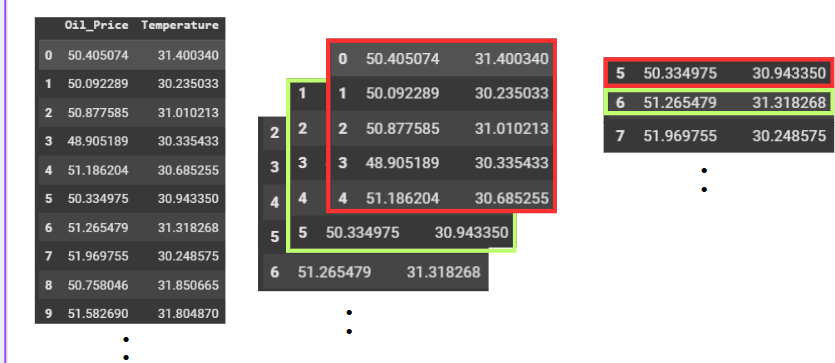

In [ ]:
time_step = 5 #ใช้ข้อมูลก่อนหน้า 5 ทำนาย


In [ ]:
# iloc[row,column]
#len(row) - time_step = n_subsets
print(len(df))


# y = 6 , x = [1,2,3,4,5]
# y = 7 , x = [2,3,4,5,6]
# ..............
# y = 500 , x = [495,496,497,498,499] 495 subsets


500


In [ ]:
X, y = [], []

for i in range(len(df) - time_step):
    X.append(df.iloc[i:i+time_step, 1:].values)  # ใช้เฉพาะฟีเจอร์ Oil_Price และ Temperature
    # iloc[0:1+5] = [0 1 2 3 4]
    y.append(df.iloc[i+time_step, 1:].values)   # Target คือค่าของวันถัดไป
    # iloc[0+5] = [6]


In [ ]:
X[:2]

[array([[49.59061251, 30.83306757],
        [49.70578797, 29.95374843],
        [51.2308521 , 29.92430444],
        [50.64677089, 31.13056162],
        [51.47263443, 30.7086211 ]]),
 array([[49.70578797, 29.95374843],
        [51.2308521 , 29.92430444],
        [50.64677089, 31.13056162],
        [51.47263443, 30.7086211 ],
        [49.17495548, 31.32629142]])]

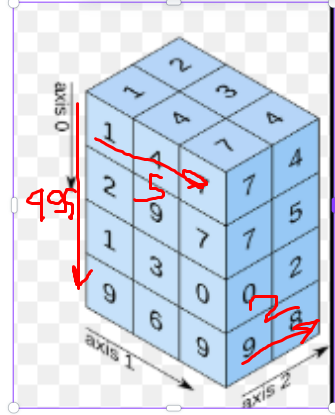

In [ ]:
# แปลงเป็น numpy array
X = np.array(X)
y = np.array(y)

# ตรวจสอบ shape
X.shape, y.shape

((495, 5, 2), (495, 2))

splitting data

In [ ]:
# แบ่งข้อมูล Train (70%) และ (Val+Test) (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False) #ห้ามสุ่มเพราะเป็น time series
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [ ]:
X_train.reshape(-1, X_train.shape[-1]) #ลดให้เหลือ 2D เพราะ standardization must 2d

array([[49.59061251, 30.83306757],
       [49.70578797, 29.95374843],
       [51.2308521 , 29.92430444],
       ...,
       [55.04296386, 35.24702028],
       [55.90031998, 37.56670755],
       [52.67531245, 35.17601308]])

In [ ]:
#แปลงกลับ
X_train.reshape(-1, X_train.shape[-1]).reshape(X_train.shape)[:2] # == x_train แปลงกลับมา 3D เหมือนเดิม

array([[[49.59061251, 30.83306757],
        [49.70578797, 29.95374843],
        [51.2308521 , 29.92430444],
        [50.64677089, 31.13056162],
        [51.47263443, 30.7086211 ]],

       [[49.70578797, 29.95374843],
        [51.2308521 , 29.92430444],
        [50.64677089, 31.13056162],
        [51.47263443, 30.7086211 ],
        [49.17495548, 31.32629142]]])

In [ ]:

# สร้างตัวแปร StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit transform กับ Training data และ Transform ชุดอื่น ๆ
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train) #y ต้องแปลงด้วยเพราะ เกิดจาก วันถัดไปของ time_step ทีตั้งเอาไว้ ค่ามันเยอะ
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# ตรวจสอบ shape
print("Train shape:", X_train_scaled.shape, y_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape, y_val_scaled.shape)
print("Test shape:", X_test_scaled.shape, y_test_scaled.shape)


Train shape: (346, 5, 2) (346, 2)
Validation shape: (74, 5, 2) (74, 2)
Test shape: (75, 5, 2) (75, 2)


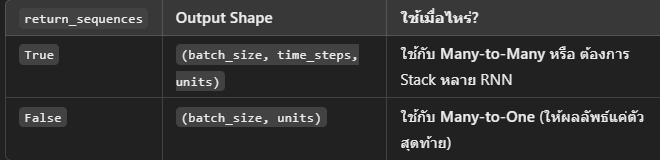

In [ ]:
"""
Many to one  = return_sequences=False
input_shape = (time_steps, features)

"""

# สร้างโมเดล SimpleRNN (Many-to-One)
model = Sequential([
    SimpleRNN(128, activation='relu', return_sequences=False, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(64, activation='relu'), #FC
    Dense(32, activation='relu'), #FC
    Dense(2)  # Output 2 ค่า (Oil_Price, Temperature)
])

# คอมไพล์โมเดล
model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse')

# Train โมเดล
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100, batch_size=64, verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.8480 - val_loss: 0.2457
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2897 - val_loss: 0.1700
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1341 - val_loss: 0.0940
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0858 - val_loss: 0.1076
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0975 - val_loss: 0.0989
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0782 - val_loss: 0.0757
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0724 - val_loss: 0.0789
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0694 - val_loss: 0.0741
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0665 - val_loss: 0.0813
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0684 - val_loss: 0.0785
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0648 - val_loss: 0.0794
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0679 - val_loss: 0.0776
E

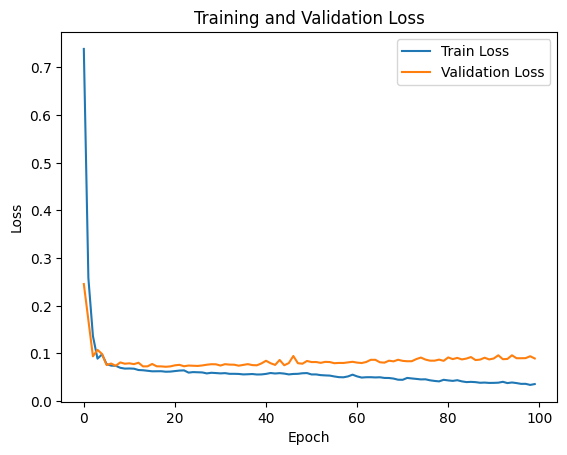

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# ทดสอบโมเดลกับ Test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled[:5]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[-1.54714   ,  1.0698397 ],
       [-1.5313522 ,  1.094751  ],
       [-1.6963713 ,  0.98185575],
       [-1.5370616 ,  1.0793527 ],
       [-1.3573186 ,  0.97821194]], dtype=float32)

In [ ]:
# แปลงค่ากลับเป็นสเกลเดิม
y_pred = scaler_y.inverse_transform(y_pred_scaled) #Nomalization ไม่ต้องแปลงกลับ
y_test = scaler_y.inverse_transform(y_test_scaled)
y_pred[:5]

array([[44.92379 , 37.686375],
       [44.97976 , 37.857727],
       [44.394756, 37.081165],
       [44.95952 , 37.75181 ],
       [45.596718, 37.0561  ]], dtype=float32)

In [ ]:
df_result = pd.DataFrame({'Actual_Oil': y_test[:, 0], 'Predicted_Oil': y_pred[:, 0],
                          'Actual_Temp': y_test[:, 1], 'Predicted_Temp': y_pred[:, 1]})
df_result

,Actual_Oil,Predicted_Oil,Actual_Temp,Predicted_Temp
0,44.412936,44.923790,37.822439,37.686375
1,45.787726,44.979759,37.737827,37.857727
2,43.977375,44.394756,38.364016,37.081165
3,45.096238,44.959518,37.282682,37.751808
4,45.904287,45.596718,36.810172,37.056099
...,...,...,...,...
70,55.658888,53.914394,25.341121,25.944187
71,53.374284,54.228191,25.788068,25.988783
72,55.141109,54.346359,25.468807,25.822786
73,54.285671,53.983459,25.994811,25.145151


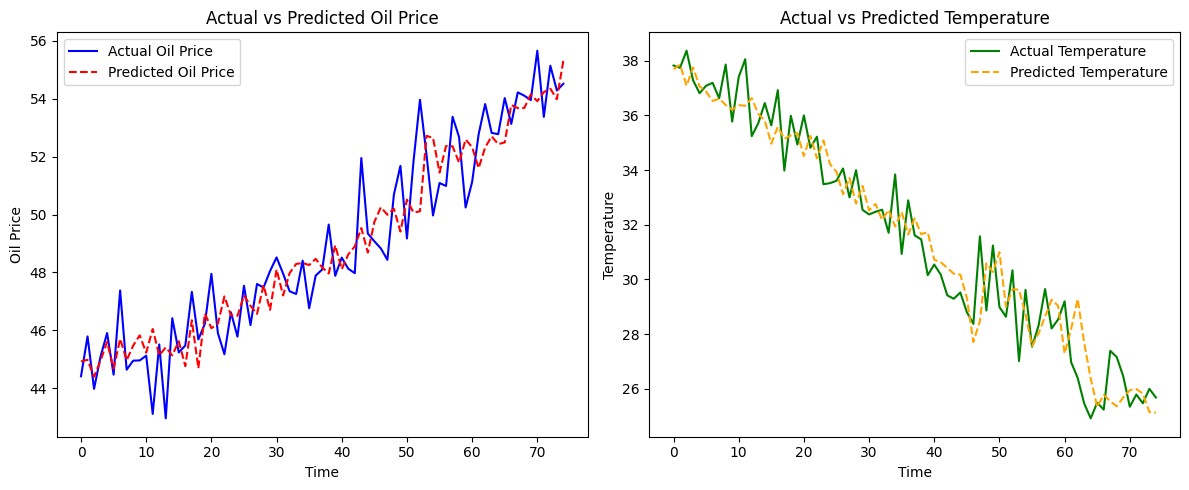

In [ ]:

# ตั้งค่าขนาดของกราฟ
plt.figure(figsize=(12, 5))

# 🔹 Plot ราคาน้ำมัน (Oil Price)
plt.subplot(1, 2, 1)  # 1 แถว 2 คอลัมน์ กราฟแรก
plt.plot(df_result['Actual_Oil'], label='Actual Oil Price', color='blue')
plt.plot(df_result['Predicted_Oil'], label='Predicted Oil Price', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.title('Actual vs Predicted Oil Price')
plt.legend()

# 🔹 Plot อุณหภูมิ (Temperature)
plt.subplot(1, 2, 2)  # กราฟที่สอง
plt.plot(df_result['Actual_Temp'], label='Actual Temperature', color='green')
plt.plot(df_result['Predicted_Temp'], label='Predicted Temperature', color='orange', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()

# แสดงกราฟ
plt.tight_layout()
plt.show()


In [ ]:
# 🔹 คำนวณ Mean Absolute Percentage Error (MAPE) เป็น Accuracy
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape  # คิดเป็น % ความแม่นยำ

print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.51%


In [ ]:
# ดึงข้อมูลล่าสุดจาก Test Set
latest_input = X_test_scaled[-1:]  # เอาข้อมูลสุดท้าย (shape = (1, time_step, features))

# ทำนายวันถัดไป
predicted_next_scaled = model.predict(latest_input)

# แปลงค่ากลับเป็นสเกลเดิม
predicted_next = scaler_y.inverse_transform(predicted_next_scaled)

# แสดงผล
print(f"พยากรณ์วันถัดไป:")
print(f"ราคาน้ำมัน (Oil Price): {predicted_next[0,0]:.2f}")
print(f"อุณหภูมิ (Temperature): {predicted_next[0,1]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
พยากรณ์วันถัดไป:
ราคาน้ำมัน (Oil Price): 55.33
อุณหภูมิ (Temperature): 25.13


การทำงาน



```
Initial Hidden State: h_0 (เวกเตอร์ขนาด 50)
                                        ↓ ใช้เป็นค่าตั้งต้น timestep 1
Timestep 1
Input [แถวที่ 1 ของ subset 1]  → Hidden State 50 node (h_1)  
                                       ↓ ส่งค่าต่อไป timestep 2
Timestep 2
Input [แถวที่ 2 ของ subset 1]  → Hidden State 50 node (h_2)  
                                       ↓ ส่งค่าต่อไป timestep 3
Timestep 3
Input [แถวที่ 3 ของ subset 1]  → Hidden State 50 node (h_3)  
                                       ↓ ส่งค่าต่อไป timestep 4
Timestep 4
Input [แถวที่ 4 ของ subset 1]  → Hidden State 50 node (h_4)  
                                       ↓ ส่งค่าต่อไป timestep 5
Timestep 5
Input [แถวที่ 5 ของ subset 1]  → Hidden State 50 node (h_5)  → Fully Connected ทำนายแถวที่ 6

```



เป็น 50 ตัวเดิม และเส้นโยงจะเชื่อมกันทั้งหมดเช่น h_1_node_1 >                       h_2_node_1 h_2_node_2 h_2_node_3 h_2_node_.... h_2_node_50